# Homework Assignment 3. Object Detection

Shall we play Quidditch? Or maybe cards instead?

In this assignment, you will almost from scratch implement an architecture for object detection, as well as use a ready-made solution. You have two datasets to choose from—they differ only in the images. Formats, scoring—everything is identical.

The first option is a dataset based on frames from the Quidditch game in Harry Potter. If you've forgotten the rules, click [here](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). You will learn to locate and highlight bludgers, the quaffle, and the snitch in photos.

The second option is a dataset with playing cards. If you've forgotten what cards are, click [here](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). You will learn to locate and highlight several types of cards in photos.

Both options contain around 300 images, and the data is stored in XML in PascalVOC format. There are minor differences, but nothing critical.

If building a custom detector is too challenging, you can move to the end after creating the datasets, where a ready-made solution is trained—it will be easier :)

### And there’s also a consultation from 2023 :)

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

The homework was tested for functionality in Colab. It is not guaranteed to work on other environments. On Windows, you'll likely encounter quite a few problems :(

For questions about phrasing (not glaring errors!), if there’s no answer in the general chat (searching the chat can help verify), you can post there with the tag @markblumenau.

Special thanks to A. Abramov for writing the assert functions to check the tasks, and to V. Gilyazov for the explanatory illustration.

## Данные
Download one of the datasets according to your preference and start working with it.
The annotations are located in the `xmls` folder, and the images are in the `images` folder.

In [ ]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2024-11-22 19:38:40--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2024-11-22 19:38:40--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   199MB/s    in 0.2s    

2024-11-22 19:38:40 (199 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Task 1. 0.5 points.

Below is the code for a standard Dataset from the PyTorch library. The Dataset requires implementing the `__getitem__` and `__len__` methods. These methods will then be used to create batches for training. Since reading from XML files is necessary, you need to first write the `get_xml_data` function to fetch annotations based on the image name.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


You can and should pass a `class_dict` to the functions. It also exists in the dataset initialization below. With its help, you can convert class names into integers. Afterward, it is assumed that the class is represented as an `int`.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # i.e., `res` looks like [xmin, ymin, xmax, ymax, class]
        # everything as int!
        # For the cells below to work correctly, a specific order of coordinates is required
        # See the documentation: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # We are interested in the pascal_voc format; it will be applied from now on.

        # This is for obtaining bounding box coordinates
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)

        # Find the class name, then look up the class identifier in the dictionary, and finally, add everything together into a list—and into bboxes, of course.
        class_name = member.find("name").text
        classI_index = class_dict[class_name]
        res =  [xmin, ymin, xmax, ymax, classI_index]
        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Having the filename, you need to load the image and bounding boxes. The function for loading bounding boxes was written above :)
        fname = self.filenames[idx]

         # Load the image here
        image = np.array(Image.open(fname).convert("RGB")) ### YOUR CODE HERE ###
        # Load bounding boxes here
        bboxes = get_xml_data(fname, self.root, self.class_dict) ### YOUR CODE HERE ###

        # transforms will be defined later for you
        # But the library is particular about the input data format, so carefully read the previous cell
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###
        # Число изображений
        return len(self.filenames)

Below, we define standard normalizations and resizing to 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Here we specify that we want the pascal_voc format
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

In [ ]:
train_ds

# Task 2. 1 point.

Now that we have loaded the data, it would be good to examine it before training any models. Write a `visualize` function that takes lists of images and bounding boxes as input and draws these boxes on the images.

The dataset includes `class_dict_inv`, which allows you to perform the reverse transformation: converting an integer representing a class into its corresponding string label.

Useful functions:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) — makes it easy to create multiple images in a single pyplot figure.
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) — displays images (don’t forget to undo the normalization).
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) — for drawing rectangles and annotation text.

In [ ]:
def visualize(images, bboxes, class_dict_inv):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Here you need to apply permute (recall where torch has channels and where matplotlib has them)
        image = images[i].permute(1, 2, 0).numpy()
        # And undo the normalization (just the inverse transformation)
        image = (image * std + mean)
        image = np.clip(image, 0, 1)
        # Class names and counts can be taken from the dataset via train_ds.class_dict_inv

        # Here display the image after undoing normalization
        ax.imshow(image) ### YOUR CODE HERE ###

        for bbox in bboxes[i]:
        # Here draw the bounding boxes
          xmin, ymin, xmax, ymax, class_id = bbox
          class_name = class_dict_inv.get(class_id)
          rectangle = Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=3, edgecolor="red", facecolor="none"
            )
          ax.add_patch(rectangle)

            # Add text with the class annotation
          ax.text(
                xmin, ymin, f"Class: {class_name}",
                color="red", fontsize=9, backgroundcolor="white"
            )
        ### YOUR CODE HERE ###


    fig.tight_layout()
    plt.show()


You should get something similar to the images for the dataset with masks:

![image](https://i.imgur.com/V5TUT26.png)

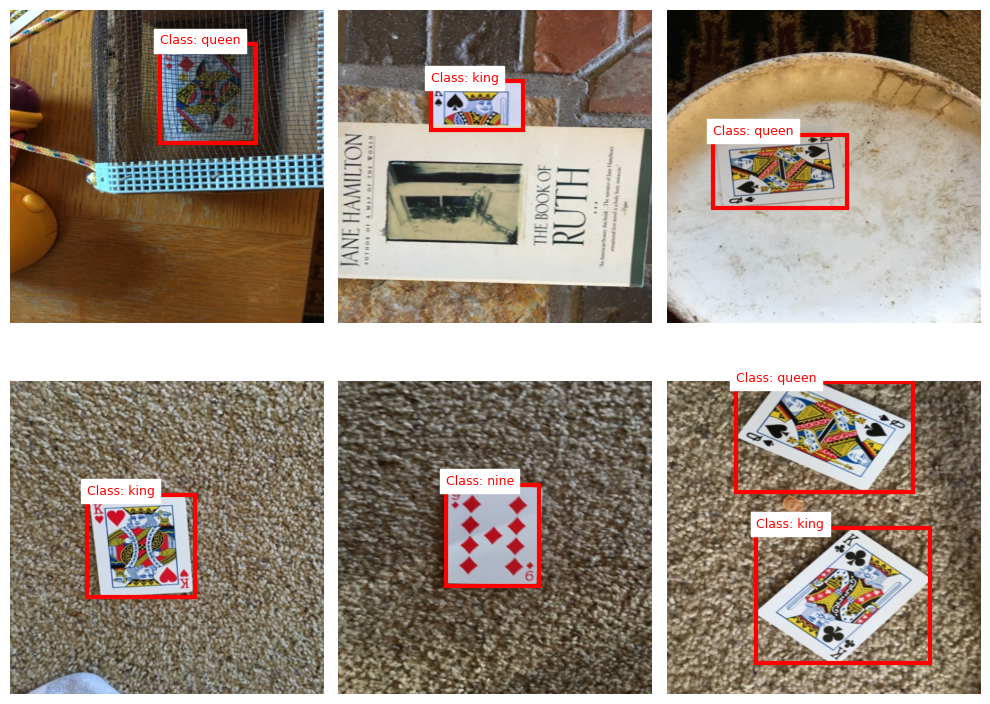

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out], train_ds.class_dict_inv)

# Task 3. 3 points.
## YOLO-like Detector

Now we need to implement a YOLO-like detector. This is one of the simplest detectors in terms of implementation. YOLO is described in the paper: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Here, we will modify and simplify it a bit. We will use ResNet for feature extraction. At the output, we will obtain a feature map of size 16x16.

## Task 3.1. 1 point.

First, we need to implement a collate function. This function allows us to customize how exactly a batch is constructed from examples (see [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) for details).

This function should take a list of bounding boxes as input and return a tensor of size Bx6x16x16. The first dimension is the number of examples in the batch. The second — "channels", the essence of which is described below. Then come the two spatial dimensions, which form a 16x16 grid. Let's fix the coordinate order as (y, x) for this 16x16 grid. This means that in the target, we will have `cy_idx, cx_idx` in this order (see the code).

In the six "channels", we will store:
* Offsets of the bbox center relative to the start of the cell (a cell is a "hyperpixel" on the 16x16 output image). These offsets will be stored in the cell they belong to. 2 channels (X, Y)
* Normalized width and height of the bbox. 2 channels (W, H)
* Grid confidence. We will use this to filter the grid's confidence in the presence of a bbox in a given cell. The target contains 1 where a bbox exists and 0 otherwise. 1 channel
* Detection class (the same integer obtained from the class name string).

### Explanatory Illustration.

It has a certain level of abstraction — for example, there should be 512 black cells, and the green one should cover 32 small black cells. But perhaps it will be clearer :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Normalize width and height by dividing by the width and height of the original image
        x_cell =  w / (w // downsample) # TODO cell size along X in pixels
        y_cell = h / (h // downsample) # TODO cell size along Y in pixels

        # The width and height of the bounding box may exceed the size of a hyperpixel
        # therefore we normalize them by the full 512
        w_box = (xmax - xmin) / w # TODO box width normalized by the size of the original image
        h_box = (ymax - ymin) / h # TODO box height normalized by the size of the original image

        # Compute center coordinates and offsets
        cx = (xmin + xmax) / 2 # TODO (center coordinates in the original coordinate space)
        cy = (ymin + ymax) / 2 # TODO
        cx_idx = (cx / x_cell).long() # TODO (compute the center index on the feature map of size 16x16; these will be the pixel coordinates where we store the box parameters)
        cy_idx = (cy / y_cell).long() # TODO

        cx_box = (cx - (cx_idx * x_cell)) / x_cell # TODO (compute offsets relative to cx_idx)
        cy_box = (cy - (cy_idx * y_cell)) / y_cell # TODO

        # cy_idx first, then cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}


You can use the following function to test your implementation. The test is not blocking.

In [ ]:
def test_collate_fn() -> None:
    target1 = [ 100, 200, 200, 300, 2 ] # xmin, ymin, xmax, ymax, class
    target2_1 = [ 0, 250, 200, 300, 0 ] # xmin, ymin, xmax, ymax, class
    target2_2 = [ 0, 100, 100, 300, 1 ] # xmin, ymin, xmax, ymax, class

    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target1 ] },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target2_1, target2_2 ] }
    ])

    # Check shapes
    assert result['image'].shape == (2, 3, 512, 512)
    assert result['target'].shape == (2, 6, 16, 16)

    # Check the values of the cells where the bounding boxes landed
    assert np.allclose(result['target'][0, :, 7, 4], torch.tensor([ 22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2 ]))
    assert np.allclose(result['target'][1, :, 8, 3], torch.tensor([ 4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0 ]))
    assert np.allclose(result['target'][1, :, 6, 1], torch.tensor([ 18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1 ]))

    # Check that all other cells contain zeros
    result['target'][0, :, 7, 4] = result['target'][1, :, 8, 3] = result['target'][1, :, 6, 1] = torch.zeros(6)
    assert np.allclose(result['target'], 0)

test_collate_fn()


Below, you can see an example of how a 16x16 grid appears on the original image:

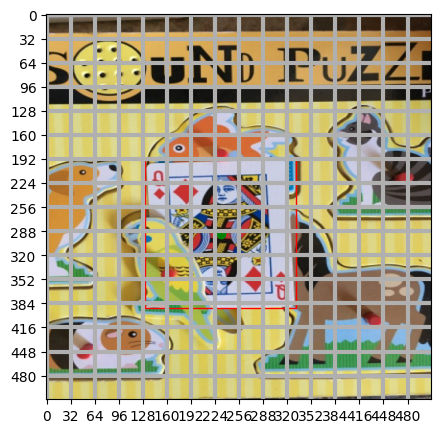

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Task 3.2. 0.5 points.

The output of our network will be slightly larger than Bx6x16x16. Why?

We are solving a task where there is more than one class. Recall the previous homework: the target was a single number, but the network's output contained a long, long vector from which we obtained the probability of belonging to one class or another. Here, it's the same but in two dimensions: each of the 16*16 cells will have its own vector of length C, which we will use to determine the class.

Implement the inverse of the collate_fn transformation to decode the neural network's output. By applying the `decode_prediction` function to the output of the collate function, you should retrieve the original set of bounding boxes with correct sizes, coordinates, and classes. When applied to the neural network's output, we should also obtain a set of bounding boxes with correct classes.

That is, you need to perform the operations from collate_fn in reverse, but take into account that the neural network's output will be slightly longer, and there you should take the argmax to determine the class.

Hint: In the target, classes come last. In the neural network output, they will also be at the end, but there will be more than one. You can check the number of channels in the incoming object: if it's 6, then it's the target, and you should take the value stored in the cell. Otherwise (if there are more than 6 channels), it's the neural network's output, and you should take the most probable one.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###
    decoded_boxes = []

    for batch_idx in range(b):
        boxes = []

        for y_idx in range(h):
            for x_idx in range(w):
                # Data for the current cell
                cell = pred[batch_idx, :, y_idx, x_idx]

                # If the input is a target
                if (c == 6):
                    confidence = cell[4].item()
                    if confidence < threshold:
                        continue
                    # Then the class is taken directly from the cell
                    class_id = int(cell[5].item())
                # If this is the network output (then the shape is greater than 6)
                else:
                    confidence = cell[4].item()
                    if confidence < threshold:
                        continue
                    # Class probabilities go after confidence
                    class_probs = cell[5:]
                    # Find the most probable class
                    class_id = int(torch.argmax(class_probs).item())

                cx_box, cy_box, w_box, h_box = cell[:4].tolist()
                cx = (x_idx + cx_box) * (img_w / w)
                cy = (y_idx + cy_box) * (img_h / h)

                box_w = w_box * img_w
                box_h = h_box * img_h

                xmin = cx - box_w / 2
                ymin = cy - box_h / 2
                xmax = cx + box_w / 2
                ymax = cy + box_h / 2

                # Append the bounding box to the list
                boxes.append([xmin, ymin, xmax, ymax, class_id])

        boxes.sort(key=lambda x: (x[0], x[1]))
        decoded_boxes.append(boxes)

    return decoded_boxes

You can use the following function to test your implementation. The test is not blocking.

In [ ]:
def test_decode_predictions() -> None:
    # Apply collate_fn to some data
    target1 = [ [ 100, 200, 200, 300, 2 ] ]
    target2 = [ [ 0, 250, 200, 300, 0 ], [ 0, 100, 100, 300, 1 ] ]
    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target1 },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target2 }
    ])

    target = result['target']
    assert target.shape == (2, 6, 16, 16)
    # In this form, target corresponds to detecting a single class — the 6th channel.
    # Add two more channels to test the function with multiple classes
    target = torch.cat([ target, torch.zeros(2, 2, 16, 16) ], dim = 1) # Add two channels
    assert target.shape == (2, 8, 16, 16) # Now there are 8 channels

    target[0, 5:, 7, 4] = torch.tensor([ 0.5, 0.6, 0.9 ]) # This should be class 2
    target[1, 5:, 8, 3] = torch.tensor([ 0.9, 0.6, 0.5 ]) # This should be class 0
    target[1, 5:, 6, 1] = torch.tensor([ 0.6, 0.9, 0.5 ]) # This should be class 1

    # Compute the result
    actual = decode_prediction(target)
    print('Actual:  ', actual)

    # The order of bounding boxes for target2 may vary depending on your implementation, and this is not an error.
    # Most likely it will be like this. But if the assertion fails, try swapping them.
    expected = [ target1, [ target2[1], target2[0] ] ]
    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- this answer is also correct.
    print('Expected:', expected)

    # Compare
    assert actual == expected

test_decode_predictions()


Actual:   [[[100.0, 200.0, 200.0, 300.0, 2]], [[0.0, 100.0, 100.0, 300.0, 1], [0.0, 250.0, 200.0, 300.0, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Task 3.3. 1 point.
Implement the model. First, apply the first 4 blocks (up to and including layer4) of ResNet50. Then add several blocks (Conv2D, BatchNorm2D, ReLU). Gradually reduce the number of channels to 5+C, and the image size to 16x16. For example, 2048 -> 512 -> 128 -> 32 -> 5+C, where C is the number of classes in your dataset. The kernel size should be 3, padding 1. But there are many options—try different ones! **The last layer must be a convolution.** Since all values we predict are in the range from 0 to 1 (thanks to normalization with the cells), we will also apply a sigmoid after the final convolution. For classes in this setup, this won’t cause any harm.

If you get creative, don’t hesitate to use layers with filters larger than 3 to achieve the correct image size after the network.

In [ ]:
with open("./data/" + "/class_dict", "r") as f:
            class_dict = eval(f.readline())

C = len(class_dict) # The number of classes in your dataset, whether you count them manually or fetch them from the class dictionary


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        ### YOUR CODE HERE ###
        self.backbone = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
        )

        self.sigmoid = nn.Sigmoid()

        self.head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1),
        )

    def forward(self, img):
        ### YOUR CODE HERE ###
        x = self.backbone(img)
        x = self.head(x)
        x = self.sigmoid(x)

        return x

## Task 3.4. 0.5 points.

Implement the loss function.

For this:
* Create a mask that indicates the positions of detectable objects. It should be used with `masked_select` (see PyTorch docs).
* The loss is similar to the original YOLO V1 loss and consists of 4 parts (with `reduction='sum'` for all):
    - Localization loss: We take MSE over the box coordinates where a detectable object exists.
    - Box loss: MSE over the square roots of the width and height of the bbox where a detectable object exists.
    - Classification loss: If a detectable object exists, compute its cross-entropy over its class.
    - Confidence loss: Binary cross-entropy for the presence of an object **FOR ALL PIXELS**. This is done separately for detectable objects (weight 1) and non-detectable objects (weight 0.1, for example, since there are many more of them, but you can experiment).

* If you follow the above description, consider the `reduction` parameter. Binary cross-entropy is called via `BCELoss`. The parameter `C` is used for the number of classes. Think about how indexing depends on the parameter `C` and use it accordingly.

In [ ]:
def special_loss(pred, target, C=C):
    ### YOUR CODE HERE ###
    # Cells with objects
    object_mask = target[:, 4, :, :] > 0
    # Cells without objects
    no_object_mask = ~object_mask

    # Losses
    mse_loss = nn.MSELoss(reduction='sum')
    bce_loss = nn.BCELoss(reduction='sum')
    cross_entropy_loss = nn.CrossEntropyLoss(reduction='sum')

    localization_loss = mse_loss(
        torch.masked_select(pred[:, 0:2, :, :], object_mask.unsqueeze(1)),
        torch.masked_select(target[:, 0:2, :, :], object_mask.unsqueeze(1))
    )

    pred_wh = torch.sqrt(torch.clamp(pred[:, 2:4, :, :], min=1e-6))
    target_wh = torch.sqrt(torch.clamp(target[:, 2:4, :, :], min=1e-6))
    box_loss = box_loss = mse_loss(
        torch.masked_select(pred_wh, object_mask.unsqueeze(1)),
        torch.masked_select(target_wh, object_mask.unsqueeze(1))
    )

    # Predicted classes
    pred_classes = pred[:, 5:, :, :]
    # Real classes
    target_classes = target[:, 5, :, :].long()


    classification_loss = cross_entropy_loss(
        pred_classes.permute(0, 2, 3, 1)[object_mask],
        target_classes[object_mask]
    )

    pred_confidence = pred[:, 4, :, :]
    target_confidence = target[:, 4, :, :]

    confidence_loss = bce_loss(
        pred_confidence[object_mask], target_confidence[object_mask]
    ) + 0.1 * bce_loss(
        pred_confidence[no_object_mask], target_confidence[no_object_mask]
    )

    return localization_loss + box_loss + classification_loss + confidence_loss

# Task 4. 2 points.

Train your model (by writing a training loop) and show that it works (objects will likely be detected in 1-2 images).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 15 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###

        images, targets = batch["image"].to(device), batch["target"].to(device)
        opt.zero_grad()

        predidctions = model(images)
        loss = special_loss(predidctions, targets, C=C).to(device)

        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        pbar.set_description(f"Epoch {e} Loss {loss.item():.3f}")

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 99.836;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 45.609;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 36.732;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 34.851;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 31.905;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 29.280;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 27.937;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 26.142;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 26.030;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 27.082;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 28.490;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 29.183;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 28.495;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 27.169;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 27.564;


Let's run the trained detector on test images:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

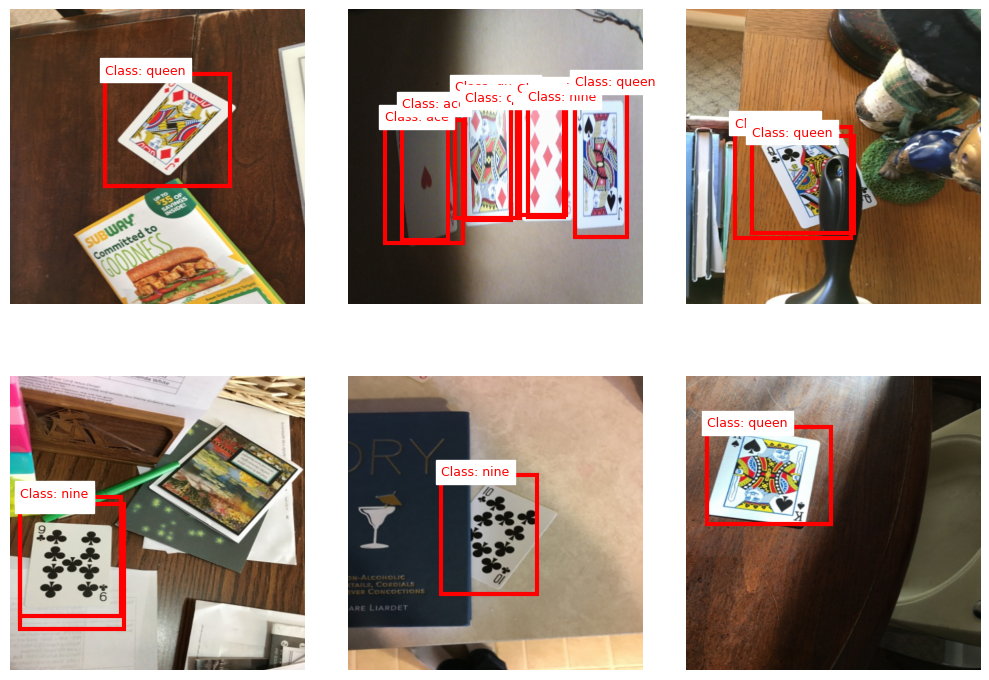

In [ ]:
# Need to make a prediction and transfer the result to CPU
# Create a visualization. Play around with the threshold—it likely needs to be lowered to around ~0.1

### YOUR CODE HERE ###

model.eval()
threshold = 0.1

with torch.no_grad():
    imgages = batch["image"].to(device)
    predictions = model(imgages)
    predictions_cpu = predictions.cpu()
    decoded_predictions = decode_prediction(predictions_cpu, threshold=threshold)

    visualize(imgages.cpu(), decoded_predictions, train_ds.class_dict_inv)

The result is pretty mediocre, right? There are many ways to improve it, the simplest of which is to attach [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.) to the output. If you're interested, you can read about YOLO v1 [here](https://arxiv.org/abs/1506.02640).

# Task 5. 3.5 points.

Let's focus on simpler tasks. We'll take a ready-made architecture, train it on our data, and see the results.

For this, we'll use YOLO 11 from Ultralytics.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 19.5 MB/s eta 0:00:00


## Task 5.1. 1.5 points.

To enable the model to be trained with a single line of code later, the data needs to be converted into the correct format. Yes, it’s the classic JSON repackaging. You can refer to [this guide](https://roboflow.com/formats/yolov8-pytorch-txt) on how to properly package the data.

In short:
* There is a .yaml file containing paths to image folders, the number of classes, and their names.
* There are `train` and `valid` folders (we’ll help you assemble these), each containing two subfolders:
    - The first is `images`, where the images are stored.
    - The second is `labels`, where files with the same names as the images are stored, but with the `.txt` extension instead of the image extension. The content follows the format described on Roboflow.


In [ ]:
# Creating folders.
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Implement a function that takes annotations in the original format and returns them in the format required for YOLO 11. This should be an array of ready strings that can be directly written to a file by adding `\n`.

Using third-party tools is not allowed; you must manually convert the format.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    yolo_an = []

    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_id = bbox

        x_center = (xmin + xmax) / 2 / w_im
        y_center = (ymin + ymax) / 2 / h_im
        width = (xmax - xmin) / w_im
        height = (ymax - ymin) / h_im

        # Forming the string.
        yolo_an.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_an

In [ ]:
# Copying images into folders and creating .txt files

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Assembling the YAML

# Specify the number of classes. You can do it manually or count it programmatically (see class_dict).
nc = len(class_dict)
# Specify the class names. You can do it manually or programmatically; it's an array of strings (see class_dict).
names = list(class_dict.keys())

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Task 5.2. 1.5 points.

Train the smallest YOLO 11 model. The library is extremely user-friendly—you only need to write two lines of code. You can use a pre-trained model.

Hint: Think about what `data.yaml` is for and what `yolo11n.yaml` is (don’t hesitate to search online).

If your loss is NaN or you are using Windows, here are some helpful links (they don’t cover all existing issues, but they might help you):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [ ]:
!wget https://raw.githubusercontent.com/ultralytics/ultralytics/main/ultralytics/cfg/models/11/yolo11.yaml

--2024-11-22 16:44:11--  https://raw.githubusercontent.com/ultralytics/ultralytics/main/ultralytics/cfg/models/11/yolo11.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1918 (1.9K) [text/plain]
Saving to: ‘yolo11.yaml’

yolo11.yaml         100%[===================>]   1.87K  --.-KB/s    in 0s      

2024-11-22 16:44:11 (37.3 MB/s) - ‘yolo11.yaml’ saved [1918/1918]



In [ ]:
import ultralytics

### YOUR CODE HERE ###

model = ultralytics.YOLO("yolo11.yaml")

model.train(data="data.yaml", epochs=15, imgsz=640, batch=16, device=0)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
WARNING ⚠️ no model scale passed. Assuming scale='n'.
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11.yaml, data=data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=

100%|██████████| 755k/755k [00:00<00:00, 21.5MB/s]


Overriding model.yaml nc=80 with nc=6
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]       

100%|██████████| 5.35M/5.35M [00:00<00:00, 82.4MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 1813.45it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1076.87it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15       5.8G      2.995       4.61      4.379         27        640: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]

                   all         37         65   0.000175     0.0407   0.000102   2.07e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.98G      3.007      4.471      4.112         20        640: 100%|██████████| 21/21 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         37         65   0.000184     0.0407   0.000111    2.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.99G      2.864      4.245      3.866         19        640: 100%|██████████| 21/21 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         37         65   0.000184     0.0407   0.000198   3.86e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.99G      2.884      3.981       3.67         22        640: 100%|██████████| 21/21 [00:06<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

                   all         37         65   0.000197     0.0407    0.00024   3.92e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      2.99G      2.838      3.947      3.525         14        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         37         65   0.000294     0.0333    0.00919    0.00366


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      3.05G      2.376      4.271      3.149         13        640: 100%|██████████| 21/21 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         37         65   0.000453      0.059   0.000298   0.000102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.97G      2.202      3.966      3.015         11        640: 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         37         65    0.00198     0.0222   0.000793   0.000343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.97G      2.154      3.879      2.924         11        640: 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         37         65      0.293     0.0111     0.0131    0.00955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      2.96G      2.093      3.701      2.776         16        640: 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


                   all         37         65      0.204     0.0111    0.00974    0.00815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.98G      1.999      3.553      2.705         10        640: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         37         65      0.059     0.0441     0.0291     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.97G      1.964      3.428      2.654          9        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         37         65     0.0663     0.0519     0.0246      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.97G      1.937      3.289      2.633          8        640: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         37         65      0.126     0.0333     0.0258     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.96G      1.912      3.233        2.6          9        640: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         37         65     0.0709     0.0573     0.0339     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      2.98G      1.844      3.136      2.535         17        640: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         37         65     0.0904     0.0997     0.0327     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.97G      1.828      3.025      2.505         13        640: 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

                   all         37         65     0.0776     0.0684      0.038     0.0271



15 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11 summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


                   all         37         65     0.0777     0.0684      0.038     0.0271
                  king         13         13     0.0494     0.0769     0.0159    0.00908
                  jack          9          9          0          0    0.00797    0.00478
                   ace         14         15      0.281        0.2      0.167       0.13
                   ten          7          8          0          0          0          0
                  nine         13         15      0.136      0.133     0.0362     0.0186
                 queen          5          5          0          0    0.00103   0.000309
Speed: 0.4ms preprocess, 3.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793eb4d32020>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Task 5.3. 0.5 points.

Visualize predictions on the validation set (at least on a subset of 5–10 images).

You can use workarounds with the `save=True` parameter in `predict`, then read them with something and plot with matplotlib. There are also better options. The default `show` will try to display via OpenCV's `imshow`, which won't work in Colab.


image 1/37 /content/valid/images/IMG_2383.JPG: 640x480 (no detections), 78.2ms
image 2/37 /content/valid/images/IMG_2384.JPG: 640x480 1 king, 2 jacks, 30.9ms
image 3/37 /content/valid/images/IMG_2389.JPG: 640x480 1 king, 34.3ms
image 4/37 /content/valid/images/IMG_2391.JPG: 640x480 1 ten, 25.9ms
image 5/37 /content/valid/images/IMG_2409.JPG: 640x480 1 ten, 35.3ms
image 6/37 /content/valid/images/IMG_2419.JPG: 640x480 (no detections), 34.3ms
image 7/37 /content/valid/images/IMG_2437.JPG: 640x480 (no detections), 52.1ms
image 8/37 /content/valid/images/IMG_2442.JPG: 640x480 (no detections), 40.6ms
image 9/37 /content/valid/images/IMG_2455.JPG: 640x480 1 king, 1 jack, 29.7ms
image 10/37 /content/valid/images/IMG_2461.JPG: 640x480 1 ten, 30.1ms
image 11/37 /content/valid/images/IMG_2464.JPG: 640x480 1 king, 1 jack, 1 queen, 30.7ms
image 12/37 /content/valid/images/IMG_2479.JPG: 640x480 1 king, 1 jack, 30.3ms
image 13/37 /content/valid/images/IMG_2491.JPG: 640x480 1 king, 1 ten, 1 nine, 86

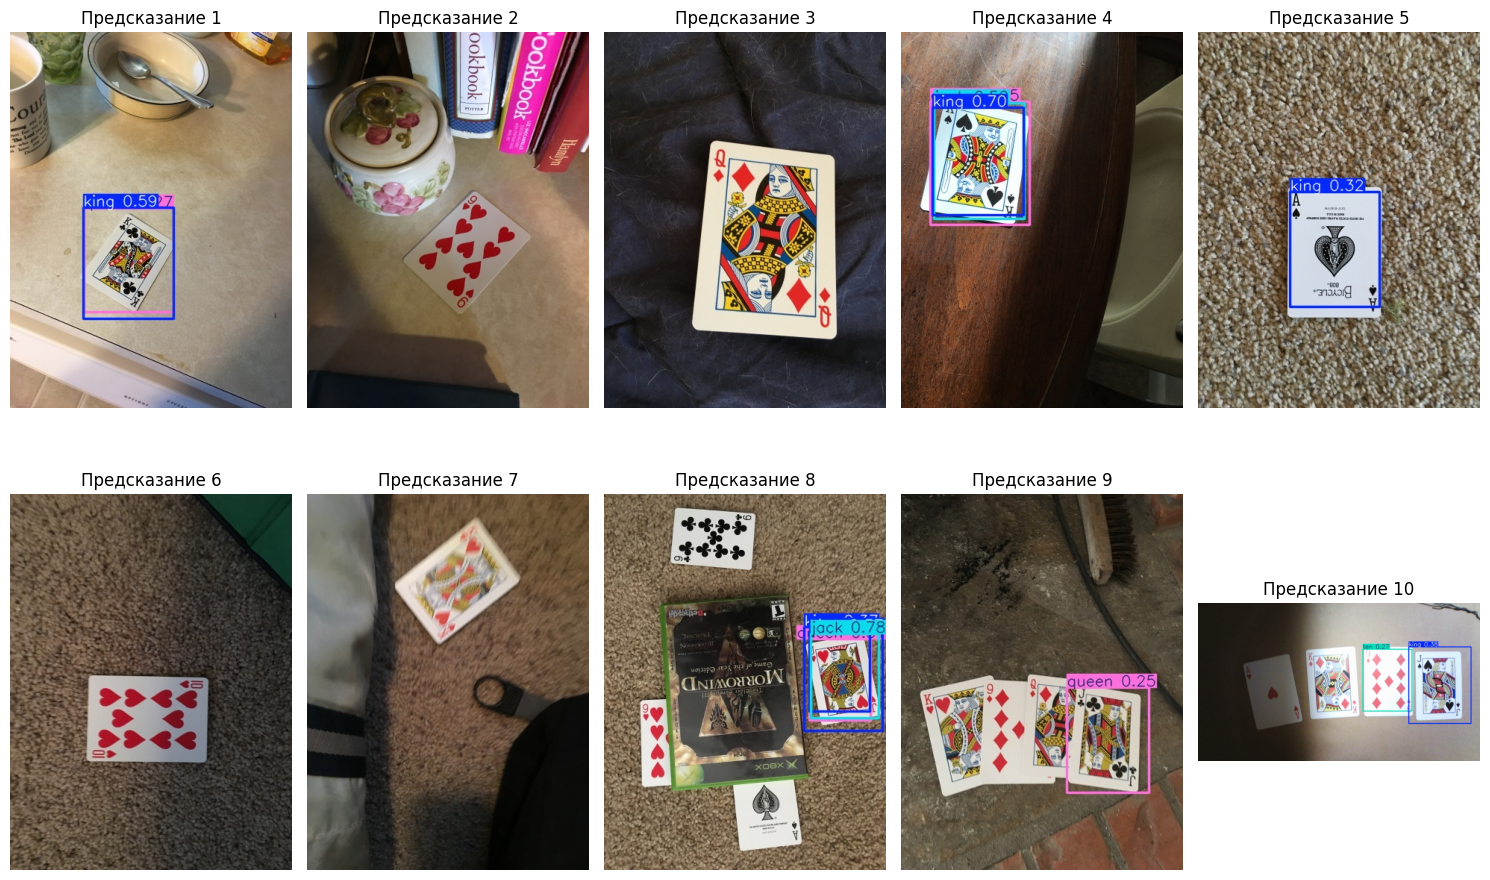

In [ ]:
### YOUR CODE HERE ###
import os

output_dir = "runs/detect/train2"

model.predict(source="./valid/images/", save=True, imgsz=640, conf=0.25)

predicted_images = os.listdir(output_dir)[:10]

plt.figure(figsize=(15, 10))
for i, img_file in enumerate(predicted_images):

    img = Image.open(os.path.join(output_dir, img_file))

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Предсказание {i + 1}")

plt.tight_layout()
plt.show()